# Methanol Synthesis Flowsheet Example

The purpose of this notebook is to demonstrate flowsheet synthesis integrating IDAES modeling tools, including the Unit Model Library, Property and Reaction Framework, IDAES scaling tools and the Process Costing Framework. The example leverages imports from external flowsheet scripts, and demonstrates implementation of separate VLE and vapor-only property packages to reduce model complexity where applicable.

## Simplified Hydrogen Reformation System

This example demonstrates a steady-state model of methanol synthesis from hydrogen and carbon monoxide. To simulate relevant natural gas components, the reactant vapors are mixed stoichiometrically and brought to optimal reaction conditions prior to entering the gas-phase reactor. Vapor liquid equilibrium is mainly applicable in the post-reactor Flash unit for methanol recovery, and is accounted for by separate vapor and VLE thermophysical property packages. See `methanol_flowsheet.py` for more information on how to assemble the flowsheet, as well as [idaes_examples.common.methanol.methanol_ideal_VLE.py](https://github.com/IDAES/examples-pse/tree/main/pkg/idaes_examples/common/methanol/methanol_ideal_VLE.py), [idaes_examples.common.methanol.methanol_ideal_vapor](https://github.com/IDAES/examples-pse/tree/main/pkg/idaes_examples/common/methanol/methanol_ideal_vapor.py) and [idaes_examples.common.methanol.methanol_reactions](https://github.com/IDAES/examples-pse/tree/main/pkg/idaes_examples/common/methanol/methanol_reactions.py) for more information on the thermophyscial and reaction properties.

This example is a reasonable approximation for gas-phase methanol synthesis systems and does not represent any particular chemical process. To simplify the system and increase tractability, hydrogen and carbon monoxide feeds are considered in lieu of multi-step mechanisms for carbon dioxide conversion to methanol. General process descriptions for gas-phase synthesis, as well as thermophysical and reaction properties for carbon monoxide hydrogenation, were taken from the following publication:

Nieminen, H.; Laari, A.; Koiranen, T. CO2 Hydrogenation to Methanol by a Liquid-Phase Process with Alcoholic Solvents: A Techno-Economic Analysis. Processes 2019, 7, 405. https://doi.org/10.3390/pr7070405

## 1. Introduction

This example demonstrates a simulation of methanol synthesis from hydrogen and carbon monoxide. Each methanol flowsheet module includes several built-in methods. This notebook demonstrates building the flowsheet, implementing model scaling, initialization and solving a square problem, costing and final constrainted optimization.

The ```build_model()``` method creates the Pyomo concrete model and builds the flowsheet by importing thermophysical and reaction properties and unit models and defining stream connections between these units. This method also implements appropriate default scaling on state and property variables.

The ```set_inputs()``` method adds the appropriate initial specifications on the feed streams and unit operations. Specifications upstream of the reactor largely remain fixed throughout the optimization.

The ```scale_flowsheet()``` method implements generic variable, unit model state variable, unit model constraint and Arc equality constraint scaling via IDAES scaling tools. Scaling factors are hard-coded in the flowsheet scripts to adjust for order of magnitude factors in appropriate constraints and simplify numerical solver calculations.

The ```initialize_flowsheet()``` method uses the initial guess to initialize the models sequentially, solving each unit and propagating the results to the outlet stream to converge the next unit more quickly. This occurs just before the flowsheet-level solver call.

The ```add_costing()``` method creates new variables and constraints related to unit model capital cost and operating cost calculations, and defines an objective function for the process economics. This method is called after the flowsheet-level solver call, and the flowsheet is resolved once costing is added. Capital costs are estimated using built-in costing methods within IDAES, and operating costs are estimated from a combination of known cost coefficients and surrogate models.

The ```report()``` method displays relevant model results after the flowsheet has been fully solved.

# 2. Problem Statement 

For given raw material flows and optimal reactor conditions, we will calculate the extent of reaction, relevant process results including reactor duty and turbine duty, methanol recovery, and relevant economic results including annual revenue.

## 2.1. Main Inputs: 
- Raw material inlets (F - mol/s, P - Pa, h - j/mol, x - mole fraction)
- Pre-reactor compressor outlet pressure (Pa)
- Pre-reactor heater outlet temperature (K)

## 2.2. Main Outputs:
- Extent of reaction (mol/s)
- Reactor duty (W)
- Turbine duty (W)
- Methanol recovery (%)
- Annual revenue (USD/year)

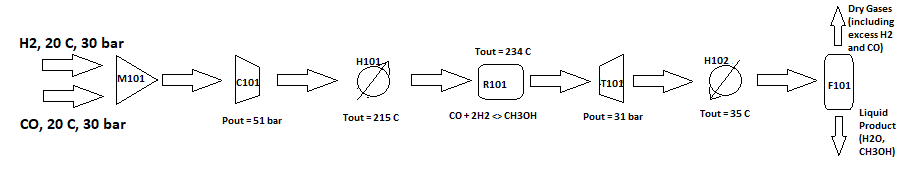

In [1]:
from IPython.display import Image
Image("methanol_flowsheet.png")

# 3. Import and Solve Flowsheet
## 3.1 Import Pyomo and IDAES Libraries

First, let's import the relevant Pyomo and IDAES Libraries:

In [2]:
import pytest
import os

# Import Pyomo libraries
from pyomo.environ import (Constraint,
                           Objective,
                           Var,
                           Expression,
                           Param,
                           ConcreteModel,
                           TransformationFactory,
                           value,
                           maximize,
                           units as pyunits)
from pyomo.environ import TerminationCondition
from pyomo.network import Arc

# Import IDAES core libraries
from idaes.core import FlowsheetBlock
from idaes.core.solvers import get_solver
from idaes.core.util import scaling as iscale
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.core.util.initialization import propagate_state

# Import required property modules
from idaes.models.properties.modular_properties.base.generic_property import \
    GenericParameterBlock
from idaes.models.properties.modular_properties.base.generic_reaction import \
    GenericReactionParameterBlock

from idaes_examples.common.methanol import methanol_ideal_VLE as thermo_props_VLE
from idaes_examples.common.methanol import methanol_ideal_vapor as thermo_props_vapor
from idaes_examples.common.methanol import methanol_reactions as reaction_props

from idaes.models.unit_models import (
    Feed,
    Mixer,
    Heater,
    Compressor,
    Turbine,
    StoichiometricReactor,
    Flash,
    Product)
from idaes.models.unit_models.mixer import MomentumMixingType
from idaes.models.unit_models.pressure_changer import ThermodynamicAssumption
from idaes.core import UnitModelCostingBlock
from idaes.models.costing.SSLW import SSLWCosting

# import flowsheet functions
from methanol_flowsheet import (
    build_model, set_inputs, scale_flowsheet, initialize_flowsheet,
    add_costing, report)

## 3.2 Build and Solve Flowsheet
The methanol flowsheet methods are called sequentially below, following the workflow contained in the ```main()``` method in `methanol_flowsheet.py`. First, let's set the solver options. IDAES contains a default solver `get_solver` which calls IPOPT using standard settings, and we set an iteration cap of 100 to catch nonconverging solver runs.

In [3]:
# Set solver options
solver = get_solver()  # IPOPT
optarg = {'tol': 1e-6,
          'max_iter': 100}
solver.options = optarg

Next, we will build and solve the initial flowsheet using imported flowsheet methods - see `methanol_flowsheet.py` for complete method scripts.

In the code below, we first define a Pyomo model object and build the model by defining each unit block with relevant property packages. As mentioned earlier, only the Flash unit (and the liquid outlet Product block) employ the VLE property package to ensure fast convergence of vapor-only processes.

The process inputs are set for stoichiometric hydrogen and carbon monoxide feeds according to the process diagram in section 2.2. In the output below, the script returns the expected degrees of freedom for the model for each unit (compressor pressure change, heater duty, reactor duty and conversion, turbine pressure change and efficiency, cooler duty and flash duty and pressure change) and the actual model degrees of freedom before input specification, after the feed inputs are specified (flow, enthalpy, pressure, and composition for each feed) and after the unit model inputs are specified.

After setting process inputs, we have a square problem for initialization. Here, we first implement IDAES scaling tools to create a more tractable problem during the solve step, and then sequentially initialize and propagate results from each unit block. As expected, the model only performs dew and bubble point calculations for the Flash and CH3OH product blocks where liquid phases are present and we obtain a square, solved problem:

In [4]:
# Build and solve flowsheet
m = ConcreteModel()
build_model(m)  # build flowsheet by adding unit models and property packages
set_inputs(m)  # unit and stream specifications
scale_flowsheet(m)  # flowsheet and unit model level scaling
initialize_flowsheet(m)  # rigorous initialization scheme

print('DOF before solve: ', degrees_of_freedom(m))
print()
print('Solving initial problem...')

results = solver.solve(m, tee=True)  # initial square problem solve

Unit degrees of freedom
M101 0
C101 1
H101 1
R101 2
T101 2
H102 1
F101 2
Total DOF:  23
DOF after streams specified:  9
DOF after units specified:  0

2022-09-23 09:00:46 [INFO] idaes.init.fs.H2.properties: Starting initialization
2022-09-23 09:00:46 [INFO] idaes.init.fs.H2.properties: Property initialization: optimal - Optimal Solution Found.
2022-09-23 09:00:46 [INFO] idaes.init.fs.H2.properties: Property package initialization: optimal - Optimal Solution Found.
2022-09-23 09:00:46 [INFO] idaes.init.fs.H2: Initialization Complete.
2022-09-23 09:00:46 [INFO] idaes.init.fs.CO.properties: Starting initialization
2022-09-23 09:00:46 [INFO] idaes.init.fs.CO.properties: Property initialization: optimal - Optimal Solution Found.
2022-09-23 09:00:46 [INFO] idaes.init.fs.CO.properties: Property package initialization: optimal - Optimal Solution Found.
2022-09-23 09:00:46 [INFO] idaes.init.fs.CO: Initialization Complete.
2022-09-23 09:00:46 [INFO] idaes.init.fs.M101.H2_WGS_state: Starting init

2022-09-23 09:00:53 [INFO] idaes.init.fs.CH3OH: Initialization Complete.
DOF before solve:  0

Solving initial problem...
Ipopt 3.13.2: tol=1e-06
max_iter=100


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must


In [5]:
# check optimal termination
assert results.solver.termination_condition == TerminationCondition.optimal

## 3.3 Flowsheet Costing and Optimization
Now that we have a well-initialized and solved flowsheet, we can add process economics and optimize the revenue. We utilize IDAES costing tools to calculate reactor and flash vessel capital cost, and implement surrogate models to account for heat exchanger capital costs. Additional, we calculate reactor operating costs as a function of conversion and assume constant rates for electricity, heating and cooling costs. Capital costs are annualized over 15 years, and revenue is determined from total liquid methanol sales, operating costs, annualized capital costs and feed raw material costs. The flowsheet report method returns key process results, including a check on the reaction stoichiometry, relevant duty and state variable values, economic results, and stream tables for feed and product streams:

In [6]:
add_costing(m)  # re-solve with costing equations
print()
print('Solving with costing...')
results2 = solver.solve(m, tee=True)

print('Initial solution process results:')
report(m)  # display initial solution results


Solving with costing...
Ipopt 3.13.2: tol=1e-06
max_iter=100


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-s

In [7]:
# check optimal termination
assert results2.solver.termination_condition == TerminationCondition.optimal

Finally, let's unfix some specifications and determine an optimal revenue. We set bounds on our decision variables to constrain our objective to physical and economically sensible solutions. The pre-reactor section mixes the feeds and brings the reactants to optimal temperature and pressure, and we only unfix downstream unit specifications:

In [8]:
# Set up Optimization Problem (Maximize Revenue)
# keep process pre-reaction fixed and unfix some post-process specs
m.fs.R101.conversion.unfix()
m.fs.R101.conversion_lb = Constraint(expr=m.fs.R101.conversion >= 0.75)
m.fs.R101.conversion_ub = Constraint(expr=m.fs.R101.conversion <= 0.85)
m.fs.R101.outlet_temp.deactivate()
m.fs.R101.outlet_t_lb = Constraint(
    expr=m.fs.R101.control_volume.properties_out[0.0].temperature
    >= 405*pyunits.K)
m.fs.R101.outlet_t_ub = Constraint(
    expr=m.fs.R101.control_volume.properties_out[0.0].temperature
    <= 505*pyunits.K)

# Optimize turbine work (or delta P)
m.fs.T101.deltaP.unfix()  # optimize turbine work recovery/pressure drop
m.fs.T101.outlet_p_lb = Constraint(
    expr=m.fs.T101.outlet.pressure[0] >= 10E5*pyunits.Pa)
m.fs.T101.outlet_p_ub = Constraint(
    expr=m.fs.T101.outlet.pressure[0] <= 51E5*0.8*pyunits.Pa)

# Optimize Cooler outlet temperature - unfix cooler outlet temperature
m.fs.H102.outlet_temp.deactivate()
m.fs.H102.outlet_t_lb = Constraint(
    expr=m.fs.H102.control_volume.properties_out[0.0].temperature
    >= 407.15*0.8*pyunits.K)
m.fs.H102.outlet_t_ub = Constraint(
    expr=m.fs.H102.control_volume.properties_out[0.0].temperature
    <= 480*pyunits.K)

m.fs.F101.deltaP.unfix()  # allow pressure change in streams

m.fs.F101.isothermal = Constraint(
    expr=m.fs.F101.control_volume.properties_out[0].temperature ==
    m.fs.F101.control_volume.properties_in[0].temperature)

print()
print('Solving optimization problem...')
opt_res = solver.solve(m, tee=True)

print('Optimal solution process results:')
report(m)


Solving optimization problem...
Ipopt 3.13.2: tol=1e-06
max_iter=100


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

As expected, the process achieves a much greater revenue as a result of increasing conversion and lowering the inlet temperature to the Flash unit to encourage methanol recovery in the liquid phase. The results show a slight increase in equipment and operating costs from these changes, as well as a small loss of methanol in the exhuast.

In [9]:
# testing model results
assert opt_res.solver.termination_condition == TerminationCondition.optimal

assert value(m.fs.R101.rate_reaction_extent[0, "R1"]) == pytest.approx(269.2805, rel=1e-5)
assert value(m.fs.R101.heat_duty[0])/1E6 == pytest.approx(-51.3636, rel=1e-5)
assert value(m.fs.T101.work_isentropic[0])/1E6 == pytest.approx(-1.9905, rel=1e-5)
assert value(m.fs.F101.recovery*100) == pytest.approx(92.8036, rel=1e-5)
assert value(m.fs.objective)/1E6 == pytest.approx(77.7005, rel=1e-5)

# 4. Problem Statement  - Analyzing Benefit of Recycling Flash Vapor

To increase the efficiency of the process as well as overall methanol production and revenue, we can add a recycle stream to send most of the Flash vapor back to the start of the process. This will reduce methanol loss in the exhaust and increase feed utilization, resulting in increased operating costs and increased production (revenue) at the same conversion. Note that for conversions less than 100%, a simulation with no purge will never converge due to accumulation of gases within the system. Therefore, to ensure we close the mass balance we set a lower bound at 10% purge from the Flash vapor to the exhaust. We expect to see a marginal increase in operating costs due to increased flow, and a much larger increase in overall production resulting in a higher total revenue.

By adding a recycle to the flowsheet, we significantly decrease the tractability of the problem and require a better initial guess. The SequentialDecomposition algorithm automatically determines a stream to *tear*, or use to break the solve loop, and iterates from a set of user-supplied initial guesses until converging on the optimal solution. The code below calls an initialization method to automatically determine the tear stream. See the initialization method of `methanol_flowsheet_w_recycle.py` for further details Sequential Decomposition scheme.

For given raw material flows and optimal reactor conditions, we will calculate the extent of reaction, relevant process results including reactor duty and turbine duty, methanol recovery, and relevant economic results including annual revenue.

## 4.1. Main Inputs: 
- Raw material inlets (F - mol/s, P - Pa, h - j/mol, x - mole fraction)
- Pre-reactor compressor outlet pressure (Pa)
- Pre-reactor heater outlet temperature (K)

## 4.2. Main Outputs:
- Extent of reaction (mol/s)
- Reactor duty (W)
- Compressor duty (W)
- Turbine duty (W)
- Methanol recovery (%)
- Purge percentage (%)
- Annual revenue (USD/year)

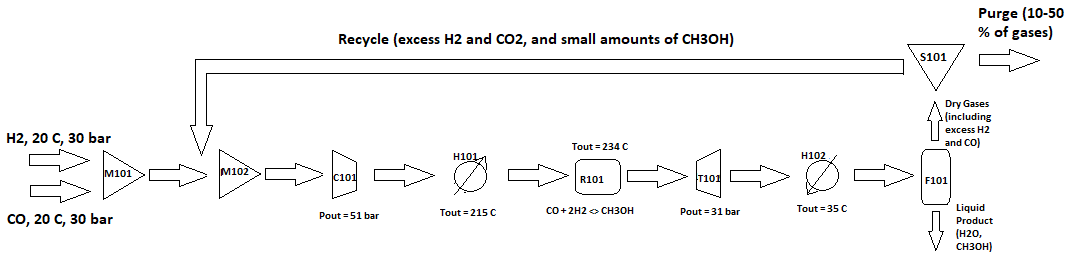

In [10]:
from IPython.display import Image
Image("methanol_flowsheet_recycle.png")

# 5. Import and Solve Recycle Flowsheet
## 5.1 Import Pyomo and IDAES Libraries
As we are rebuilding the model, we need to import require Pyomo and IDAES libraries:

In [11]:
import pytest
import os
# Import Pyomo libraries
from pyomo.environ import (Constraint,
                           Objective,
                           Var,
                           Expression,
                           Param,
                           ConcreteModel,
                           TransformationFactory,
                           value,
                           maximize,
                           units as pyunits)
from pyomo.environ import TerminationCondition
from pyomo.network import Arc, SequentialDecomposition

# Import IDAES core libraries
from idaes.core import FlowsheetBlock
from idaes.core.solvers import get_solver
from idaes.core.util import scaling as iscale
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.core.util.initialization import propagate_state

# Import required models

from idaes.models.properties.modular_properties.base.generic_property import \
    GenericParameterBlock
from idaes.models.properties.modular_properties.base.generic_reaction import \
    GenericReactionParameterBlock

from idaes_examples.common.methanol import methanol_ideal_VLE as thermo_props_VLE
from idaes_examples.common.methanol import methanol_ideal_vapor as thermo_props_vapor
from idaes_examples.common.methanol import methanol_reactions as reaction_props

from idaes.models.unit_models import (
    Feed,
    Mixer,
    Heater,
    Compressor,
    Turbine,
    StoichiometricReactor,
    Flash,
    Separator as Splitter,
    Product)
from idaes.models.unit_models.mixer import MomentumMixingType
from idaes.models.unit_models.pressure_changer import ThermodynamicAssumption
from idaes.core import UnitModelCostingBlock
from idaes.models.costing.SSLW import SSLWCosting
import idaes.logger as idaeslog

# import flowsheet functions
from methanol_flowsheet_w_recycle  import (
    build_model, set_inputs, scale_flowsheet, initialize_flowsheet,
    add_costing, report)

## 5.2 Build and Solve Recycle Flowsheet
As before, we will first build the flowsheet, set required inputs, initialize and solve a square problem. Recycling methanol to pre-reactor blocks complicates VLE calculations, and limiting VLE calculations to the Flash unit and liquid Product block greatly increases tractability during initialization. All initial feed and unit specifications are identical to the non-recycle case; the Sequential Decomposition algorithm automatically selects the compressor feed as the tear stream and uses "no recycle" results as a first guess. In the output below, the solver solves all units and then resolves select blocks with updated inlet results, followed by a full flowsheet solve:

In [12]:
# Build and solve flowsheet
solver = get_solver()  # IPOPT
optarg = {'tol': 1e-6,
          'max_iter': 100}
solver.options = optarg

m = ConcreteModel()  # create a new model so we may reference 'm' below
build_model(m)  # build flowsheet
set_inputs(m)  # unit and stream specifications
scale_flowsheet(m)  # flowsheet and unit model level scaling

# let the solver determine the tear stream
initialize_flowsheet(m)  # rigorous initialization scheme

print('DOF before solve: ', degrees_of_freedom(m))
print()
print('Solving initial problem...')
results = solver.solve(m, tee=True)

Unit degrees of freedom
M101 0
C101 1
H101 1
R101 2
T101 2
H102 1
F101 2
M102 0
S101 1
Total DOF:  24
DOF after streams specified:  10
DOF after units specified:  0

Tear Stream:
fs.s02 :  fs.M102.outlet  to  fs.C101.inlet

Calculation order:
fs.H2
fs.M101
fs.R101
fs.T101
fs.H102
fs.F101
fs.S101
fs.EXHAUST

Initial DOF =  0
Solving  fs.H2
DOF =  0
Solving  fs.CO
DOF =  0
Solving  fs.C101
DOF =  0
Solving  fs.M101
DOF =  0
Solving  fs.H101
DOF =  0
Solving  fs.R101
DOF =  0
Solving  fs.T101
DOF =  0
Solving  fs.H102
DOF =  0
Solving  fs.F101
DOF =  0
Solving  fs.S101
DOF =  0
Solving  fs.CH3OH
DOF =  0
Solving  fs.EXHAUST
DOF =  0
Solving  fs.M102
DOF =  0
Solving  fs.H2
DOF =  0
Solving  fs.CO
DOF =  0
Solving  fs.M101
DOF =  0
Solving  fs.EXHAUST
DOF =  0
Solving  fs.CH3OH
DOF =  0
Final DOF =  0
DOF before solve:  0

Solving initial problem...
Ipopt 3.13.2: tol=1e-06
max_iter=100


******************************************************************************
This program contains Ip

In [13]:
# check optimal termination
assert results.solver.termination_condition == TerminationCondition.optimal

## 5.3 Flowsheet Costing and Optimization
Now that we have a well-initialized and solved flowsheet, we can add process economics and optimize the revenue. We utilize IDAES costing tools to calculate reactor and flash vessel capital cost, and implement surrogate models to account for heat exchanger capital costs, reactor operating costs and utility costs for heating, cooling and electricity. As before, revenue is determined from total liquid methanol sales, operating costs, annualized capital costs and feed raw material costs. The flowsheet report method returns key process results, which are updated for new results with the prescence of a recycle stream:

In [14]:
add_costing(m)  # re-solve with costing equations
print()
results2 = solver.solve(m, tee=True)

print('Initial solution process results:')
report(m)  # display initial solution results


Ipopt 3.13.2: tol=1e-06
max_iter=100


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        

In [15]:
# check optimal termination
assert results2.solver.termination_condition == TerminationCondition.optimal

Finally, let's unfix some specifications and determine an optimal revenue. We set bounds on our decision variables to constrain our objective to physical and economically sensible solutions, including a purge between 10-50% of flash vapor. The pre-reactor section mixes the feeds and brings the reactants to optimal temperature and pressure, and we only unfix downstream unit specifications:

In [16]:
# Set up Optimization Problem (Maximize Revenue)
# keep process pre-reaction fixed and unfix some post-process specs
m.fs.R101.conversion.unfix()
m.fs.R101.conversion_lb = Constraint(expr=m.fs.R101.conversion >= 0.75)
m.fs.R101.conversion_ub = Constraint(expr=m.fs.R101.conversion <= 0.85)
m.fs.R101.outlet_temp.deactivate()
m.fs.R101.outlet_t_lb = Constraint(
    expr=m.fs.R101.control_volume.properties_out[0.0].temperature
    >= 405*pyunits.K)
m.fs.R101.outlet_t_ub = Constraint(
    expr=m.fs.R101.control_volume.properties_out[0.0].temperature
    <= 505*pyunits.K)

# Optimize turbine work (or delta P)
m.fs.T101.deltaP.unfix()  # optimize turbine work recovery/pressure drop
m.fs.T101.outlet_p_lb = Constraint(
    expr=m.fs.T101.outlet.pressure[0] >= 10E5*pyunits.Pa)
m.fs.T101.outlet_p_ub = Constraint(
    expr=m.fs.T101.outlet.pressure[0] <= 51E5*0.8*pyunits.Pa)

# Optimize Cooler outlet temperature - unfix cooler outlet temperature
m.fs.H102.outlet_temp.deactivate()
m.fs.H102.outlet_t_lb = Constraint(
    expr=m.fs.H102.control_volume.properties_out[0.0].temperature
    >= 407.15*0.8*pyunits.K)
m.fs.H102.outlet_t_ub = Constraint(
    expr=m.fs.H102.control_volume.properties_out[0.0].temperature
    <= 480*pyunits.K)

m.fs.F101.deltaP.unfix()  # allow pressure change in streams

m.fs.F101.isothermal = Constraint(
    expr=m.fs.F101.control_volume.properties_out[0].temperature ==
    m.fs.F101.control_volume.properties_in[0].temperature)

m.fs.S101.split_fraction[0, "purge"].unfix()  # allow some gas recycle
m.fs.S101.split_fraction_lb = Constraint(
    expr=m.fs.S101.split_fraction[0, "purge"] >= 0.10)  # min 10% purge
m.fs.S101.split_fraction_ub = Constraint(
    expr=m.fs.S101.split_fraction[0, "purge"] <= 0.50)  # max 50% purge

print()
print('Solving optimization problem...')
opt_res = solver.solve(m, tee=True)

print('Optimal solution process results:')
report(m)


Solving optimization problem...
Ipopt 3.13.2: tol=1e-06
max_iter=100


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

Optimal solution process results:


Extent of reaction:  311.30698549500477
Stoichiometry of each component normalized by the extent:
CH4 :  -0.0
H2 :  -2.0
CH3OH :  1.0
CO :  -1.0
These coefficients should follow 1*CO + 2*H2 => 1*CH3OH

Reaction conversion:  0.8500000099996615
Reactor duty (MW):  -59.34022107299142
Duty from Reaction (MW)): 28.216865165267233
Compressor work (MW):  -1.0259209299738811e-24
Turbine work (MW):  -2.4913012083835544
Feed Mixer outlet temperature (C)):  20.051714213753428
Recycle Mixer outlet temperature (C)):  41.543214378017694
Feed Compressor outlet temperature (C)):  41.543214378017694
Feed Compressor outlet pressure (Pa)):  5100000.0
Heater outlet temperature (C)):  215.0
Reactor outlet temperature (C)):  231.85000478420352
Turbine outlet temperature (C)):  141.5003786288168
Turbine outlet pressure (Pa)):  1487177.2483577363
Cooler outlet temperature (C)):  52.56999699056837
Flash outlet temperature (C)):  134.0
Purge percentage (amount of vapor vented

As expected, recycling methanol and gases from the flash vapor achieves much greater methanol production, and process cost increases are small compared to the increase in revenue. Note that the reaction conversion and flash inlet temperature did not change, and we obtain the same percentage methanol recovery. We can see in the stream tables that far more of the inlet material exits as methanol than in the non-recycle process (note that we do not have a mole balance due to the reaction stoichiometry). The results show a slight increase in equipment and operating costs from increased throughput on each unit.

In [17]:
# testing model results
assert opt_res.solver.termination_condition == TerminationCondition.optimal

assert value(m.fs.R101.rate_reaction_extent[0, "R1"]) == pytest.approx(311.3070, rel=1e-5)
assert value(m.fs.R101.heat_duty[0])/1E6 == pytest.approx(-59.3402, rel=1e-5)
assert value(m.fs.C101.work_mechanical[0])/1E6 == pytest.approx(0, abs=1e-5)
assert value(m.fs.T101.work_isentropic[0])/1E6 == pytest.approx(-2.4913, rel=1e-5)
assert value(m.fs.F101.recovery*100) == pytest.approx(92.0589, rel=1e-5)
assert value(m.fs.S101.split_fraction[0, "purge"]*100) == pytest.approx(10.0000, rel=1e-5)
assert value(m.fs.objective)/1E6 == pytest.approx(104.2789, rel=1e-5)

# 6. Summary
The present example demonstrates building, initializing and optimizing a methanol synthesis problem in IDAES. The imported scripts implement models from the IDAES pre-defined unit model library, the IDAES Property and Reaction Framework, targeted thermophysical properties for specific unit blocks, Pyomo's Sequential Decomposition methods, the IDAES Costing Framework for capital cost calculations, and integration of custom surrogate expressions for operating cost calculations. The methanol synthesis flowsheet methods may be imported into any external script, and users may build, initialize and optimize the entire model via the `main()` method in each flowsheet.